In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
rng = np.random.default_rng()

In [2]:
# Note -- place your own MNIST files in the appropriate directory
train_data = np.loadtxt("./data/mnist/mnist_train.csv", delimiter=',')
test_data = np.loadtxt("./data/mnist/mnist_test.csv", delimiter=',')

In [3]:
train_imgs = train_data[:, 1:]  # (60000, 784)
test_imgs = test_data[:, 1:]  # (10000, 784)
train_labels = train_data[:, 0]  # (60000, )
test_labels = test_data[:, 0]  # (10000, )

In [26]:
# Change the top k input values to 1, rest of the values to 0
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

In [27]:
n_in = 784
n_neurons = 2000
n_out = 2000
cap_size = 200
sparsity = 0.1
n_rounds = 5
beta = 1e0

mask = np.zeros((n_neurons, n_neurons), dtype=bool)
W = np.zeros((n_neurons, n_neurons))

mask_a = np.zeros((n_in, n_neurons), dtype=bool)
A = np.zeros((n_in, n_neurons))

mask_c = np.zeros((n_neurons, n_out), dtype=bool)
C = np.zeros((n_neurons, n_out))

# Random mask on inter-area connections
# Choose 10% of connections and not the diagnal
mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
W = np.ones((n_neurons, n_neurons)) * mask
W /= W.sum(axis=0)

# Random mask on input-learning area connections
mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

# Random mask on learning-output area connections
mask_c = rng.random((n_neurons, n_out)) < sparsity
C = np.ones((n_neurons, n_out)) * mask_c
C /= A.sum(axis=0)

In [28]:
from scipy.signal import convolve
# k-cap on convolved input pixels
n_examples = 5000
examples = np.zeros((10, n_examples, 784))
for i in range(10):
    examples[i] = k_cap(convolve(train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), cap_size)

In [30]:
# Init connections from each neuron to sum up to 1
W = np.ones_like(W) * mask
A = np.ones_like(A) * mask_a
C = np.ones_like(C) * mask_c
W /= W.sum(axis=0, keepdims=True)
A /= A.sum(axis=0, keepdims=True)
C /= C.sum(axis=0, keepdims=True)

bias = np.zeros(n_neurons)
b = -1

activations = np.zeros((10, n_rounds, n_neurons))
activations_out = np.zeros((10, n_out))

# Iterate over each class
for i in range(10):
    
    # Apply supervision: set assembly in the output area corresponding to class i to 1
    activations_out[i, i*cap_size:i*cap_size+cap_size] = 1
    
    act_h = np.zeros(n_neurons)
    
    # Iterate over several examples
    for j in range(n_rounds):
        
        input = examples[i, j]
        
        # calculate activation
        act_h_new = k_cap(act_h @ W + input @ A + bias, cap_size)
        activations[i, j] = act_h_new.copy()
        
        # update weights
        A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        C[(act_h_new > 0)[:, np.newaxis] & (activations_out[i] > 0)[np.newaxis, :]] *= 1 + beta
        
        act_h = act_h_new
        
    bias[act_h > 0] += b
    A /= A.sum(axis=0, keepdims=True)
    W /= W.sum(axis=0, keepdims=True)
    C /= C.sum(axis=0, keepdims=True)

In [31]:
act_l = np.zeros((10, n_rounds+1, n_examples, n_neurons))
outputs = np.zeros((10, n_rounds+1, n_examples, n_out))
for i in np.arange(10):
    # Run each example through the model n_round times
    for j in range(n_rounds):
        act_l[i, j+1] = k_cap(act_l[i, j] @ W + examples[i] @ A, cap_size)
        outputs[i, j+1] = k_cap(act_l[i, j+1] @ C, cap_size)

In [32]:
outputs.shape

(10, 6, 5000, 2000)

In [36]:
idx = np.arange(n_out)
idx

array([   0,    1,    2, ..., 1997, 1998, 1999])

<IPython.core.display.Javascript object>


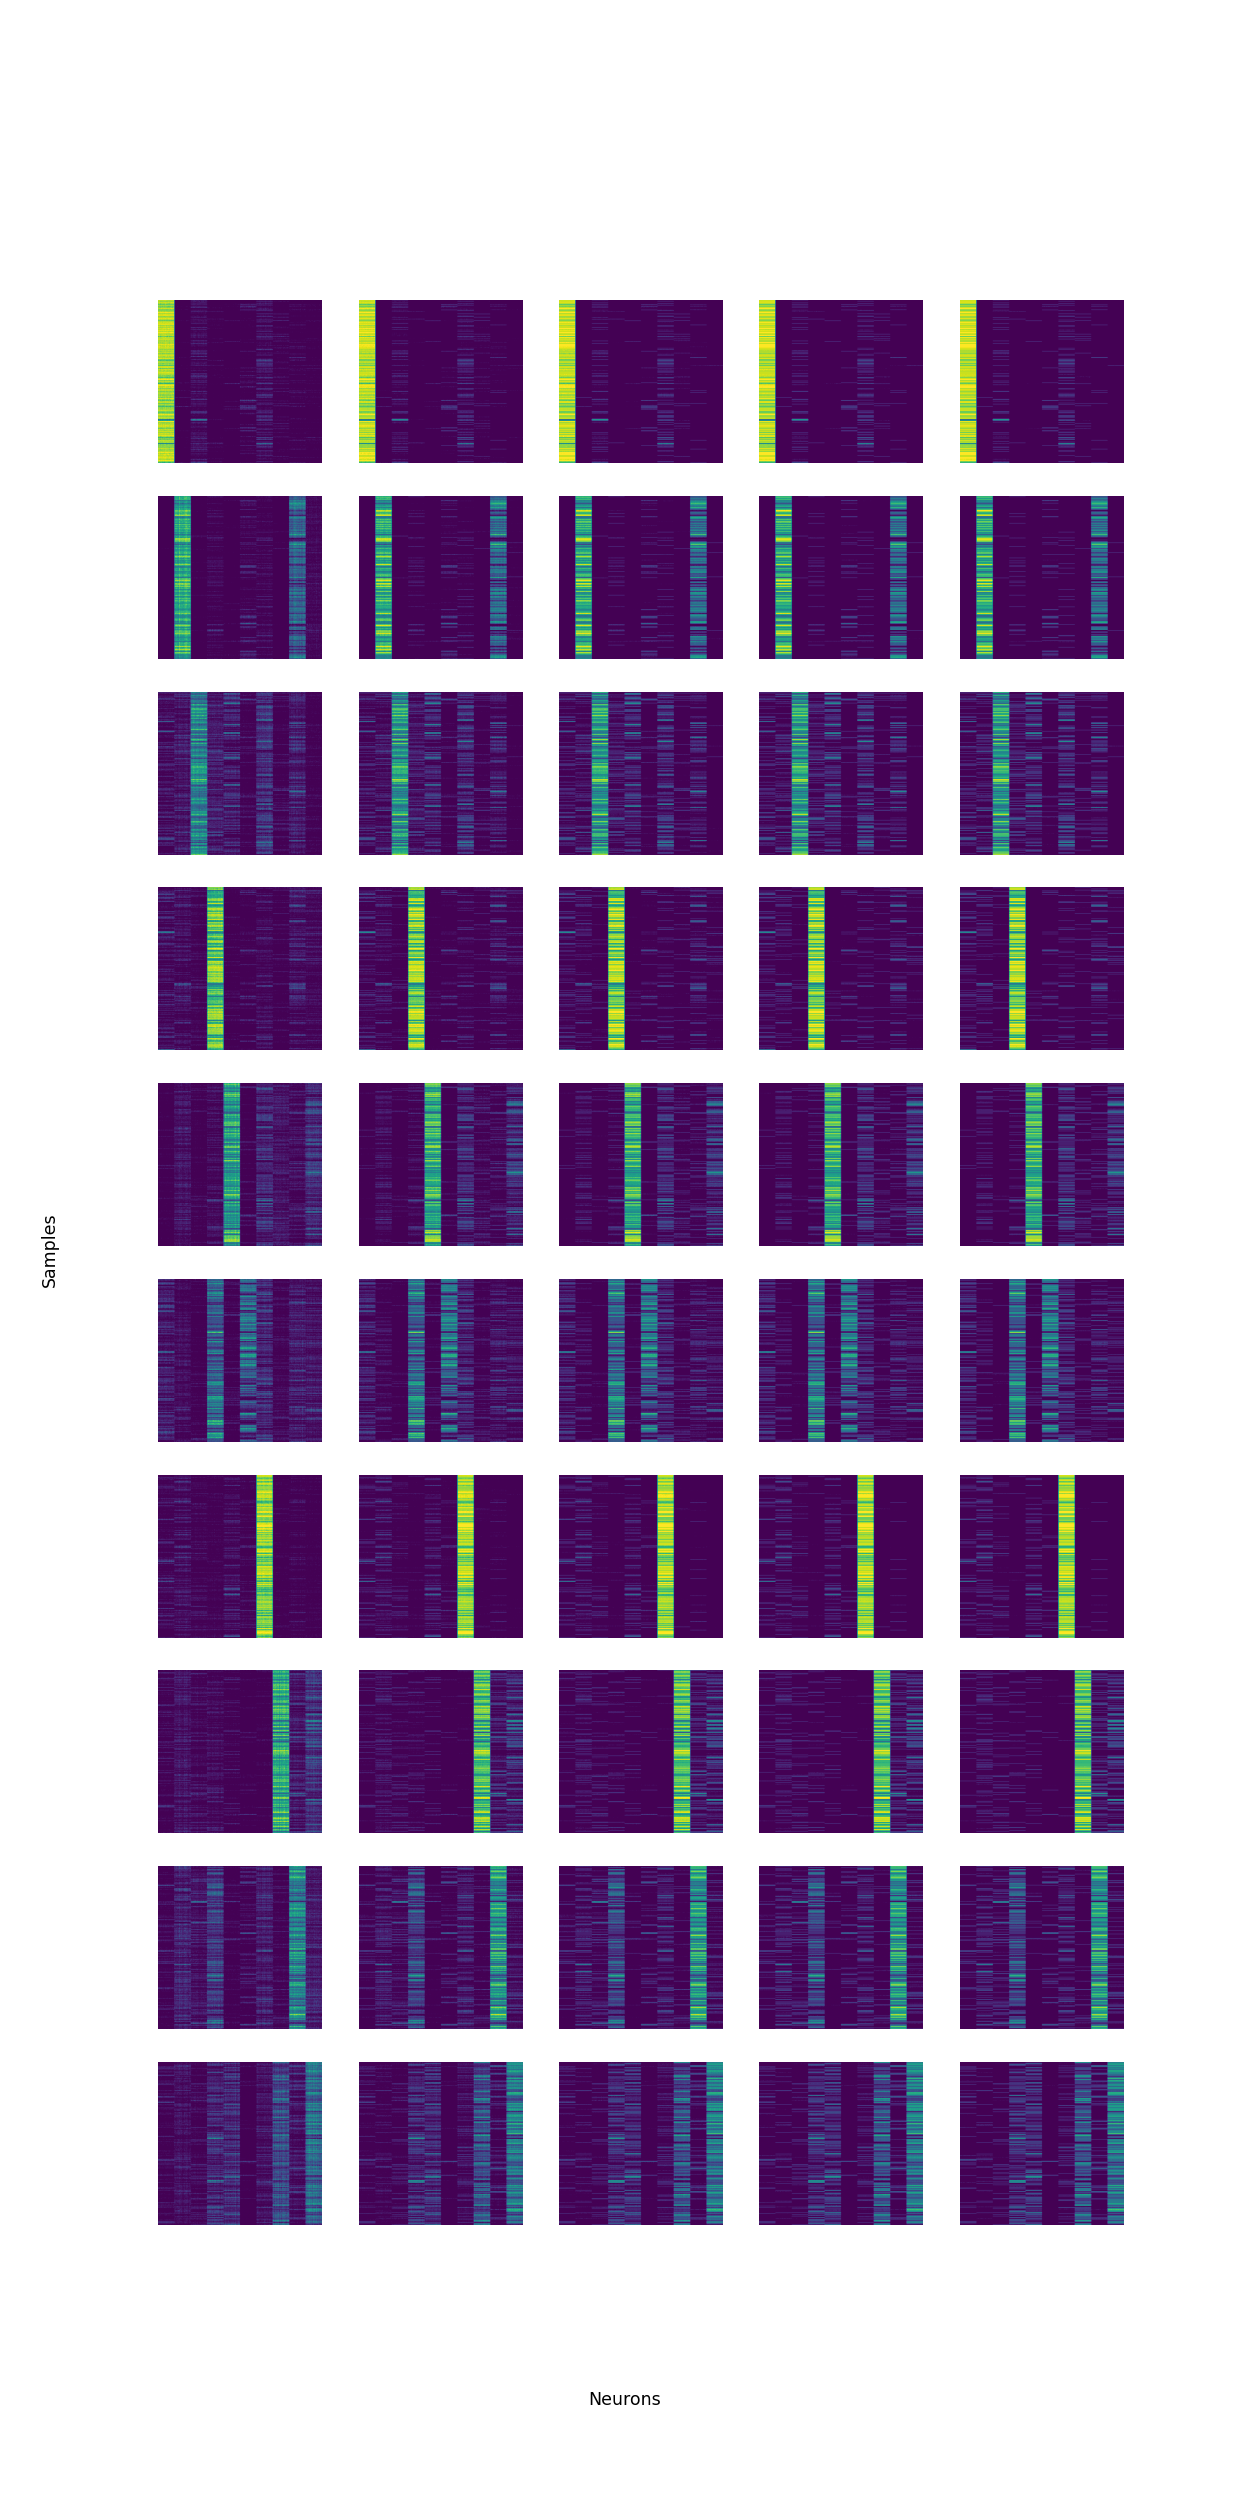

Text(0.04, 0.5, 'Samples')

In [37]:
fig, axes = plt.subplots(10, n_rounds, figsize=(10, 2 * 10), sharex=True, sharey=True)
for ax, output in zip(axes, outputs):
    for i in range(n_rounds):
        ax[i].imshow((output[i+1] > 0)[:n_neurons, idx])
        ax[i].set_axis_off()
fig.text(0.5, 0.04, 'Neurons', ha='center', va='center')
fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')

In [12]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1, keepdims=True)

In [13]:
v = 0.1 * rng.standard_normal((10, n_neurons))
targets = np.zeros((100, 10))

for i in range(10):
    targets[i*10:(i+1)*10, i] = 1
update = np.zeros_like(v)

In [14]:
for _ in range(100):
    permutation = rng.permutation(n_examples - 1000)
    for j in range((n_examples - 1000) // 10):
        batch = outputs[:, 1, permutation[j*10:(j+1)*10]].reshape(10 * 10, n_neurons)
        scores = softmax((batch[:, :, np.newaxis] * v.T[np.newaxis, :, :]).sum(axis=1))
        update = 0.5 * update + 1e-3 * (batch[:, np.newaxis, :] * (scores - targets)[:, :, np.newaxis]).sum(axis=0)
        v -= update

In [14]:
((outputs[:, 1, :-1000] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 40000

0.998675

In [15]:
((outputs[:, 1, -1000:] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 10000

0.9265

<IPython.core.display.Javascript object>


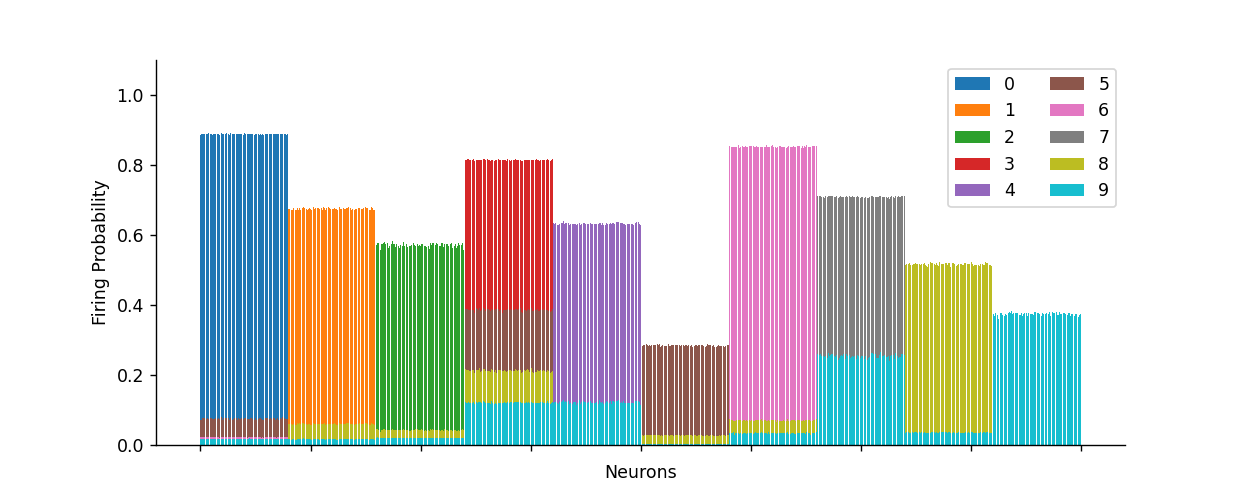

Text(0, 0.5, 'Firing Probability')

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(10):
    # Pass each sample to the model and get its result 
    ax.bar(np.arange(n_neurons), outputs[i, -1].mean(axis=0)[idx], label=i)
ax.legend(loc='upper right', ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 1.1])
ax.set_xticklabels([])
ax.set_xlabel('Neurons')
ax.set_ylabel('Firing Probability')

In [41]:
# We know the assembly of the output area by construction
c = np.zeros((10, n_neurons))
for i in range(10):
    c[i, i*cap_size: i*cap_size+cap_size] = 1

In [42]:
predictions = (outputs[:, 1] @ c.T).argmax(axis=-1)
acc = (predictions == np.arange(10)[:, np.newaxis]).sum(axis=-1) / n_examples

In [44]:
acc, acc.mean()

(array([0.8872, 0.6716, 0.5526, 0.8128, 0.617 , 0.2816, 0.858 , 0.6928,
        0.5126, 0.3946]),
 0.62808)

<IPython.core.display.Javascript object>


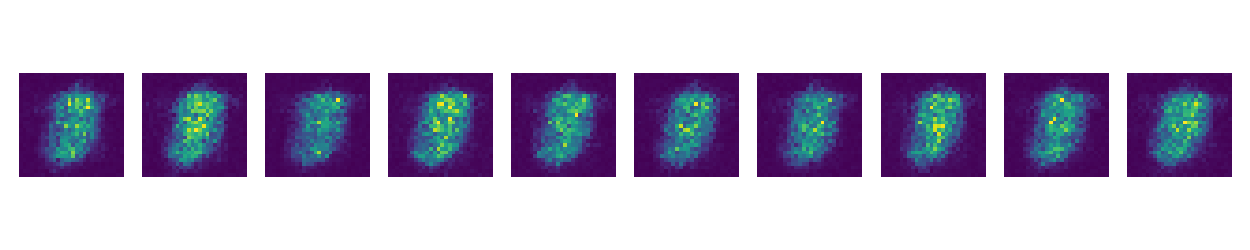

In [45]:
# Ignore this for now because now we cannot map c back to sensory area
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    axes[i].imshow((A * c[i][np.newaxis, :]).sum(axis=1).reshape(28, 28))
    axes[i].set_axis_off()
fig.tight_layout()